<a href="https://colab.research.google.com/github/shaiksameerss9124/Bajaj-Finserv-Health_project/blob/master/MOVIE_SUCESS_PREDICTGION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("/content/movie_metadata.csv")

# Step 1: Define success label
df['success'] = (df['imdb_score'] >= 6.5).astype(int)  # You can change threshold as needed

# Step 2: Drop rows with missing critical values
df.dropna(subset=['director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name', 'genres'], inplace=True)

# Step 3: Helper function to compute genre-specific success ratios
def compute_genre_success_ratio(df, role_col, success_col='success'):
    ratios = df.groupby([role_col, 'genres'])[success_col].mean().reset_index()
    ratios.columns = [role_col, 'genres', 'success_ratio']
    return ratios

# Step 4: Compute and merge success ratios
df = df.merge(compute_genre_success_ratio(df, 'director_name').rename(columns={'success_ratio': 'director_ratio'}),
              on=['director_name', 'genres'], how='left')

df = df.merge(compute_genre_success_ratio(df, 'actor_1_name').rename(columns={'success_ratio': 'actor1_ratio'}),
              on=['actor_1_name', 'genres'], how='left')

df = df.merge(compute_genre_success_ratio(df, 'actor_2_name').rename(columns={'success_ratio': 'actor2_ratio'}),
              on=['actor_2_name', 'genres'], how='left')

df = df.merge(compute_genre_success_ratio(df, 'actor_3_name').rename(columns={'success_ratio': 'actor3_ratio'}),
              on=['actor_3_name', 'genres'], how='left')

# Step 5: Select features and target
X = df[['director_ratio', 'actor1_ratio', 'actor2_ratio', 'actor3_ratio',
        'genres', 'content_rating', 'language', 'country']]
y = df['success']

# Step 6: Define column types
numerical_cols = ['director_ratio', 'actor1_ratio', 'actor2_ratio', 'actor3_ratio']
categorical_cols = ['genres', 'content_rating', 'language', 'country']

# Step 7: Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean'))
    ]), numerical_cols),

    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_cols)
])

# Step 8: Full pipeline with Random Forest
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Step 9: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 10: Train model
model.fit(X_train, y_train)

# Step 11: Evaluate
y_pred = model.predict(X_test)
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Step 12: Save model
joblib.dump(model, "movie_success_genrewise_predictor.pkl")
print("✅ Model saved as movie_success_genrewise_predictor.pkl")


✅ Accuracy: 0.9989837398373984
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       473
           1       1.00      1.00      1.00       511

    accuracy                           1.00       984
   macro avg       1.00      1.00      1.00       984
weighted avg       1.00      1.00      1.00       984

✅ Model saved as movie_success_genrewise_predictor.pkl


# **1.Confusion Matrix Plot**

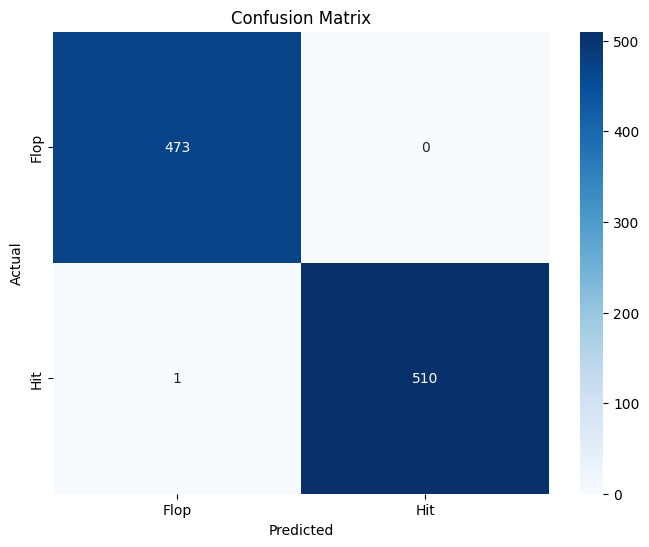

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Flop', 'Hit'], yticklabels=['Flop', 'Hit'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# **Histogram of Actual vs Predicted**

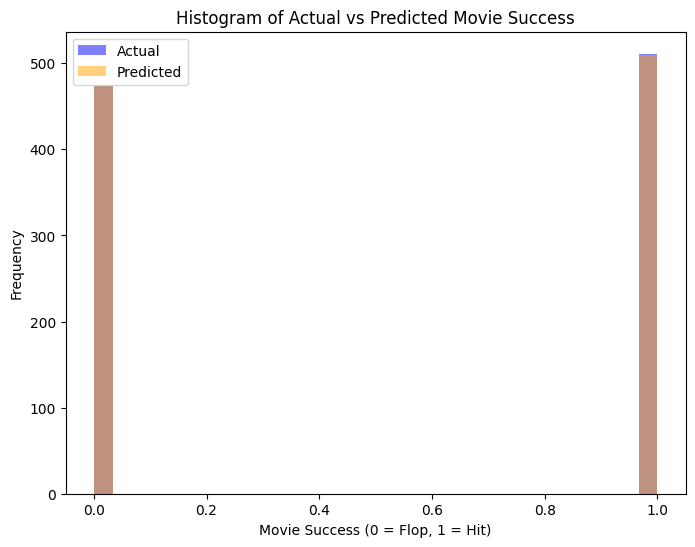

In [ ]:
plt.figure(figsize=(8, 6))  # Set the figure size for the plot
plt.hist(y_test, bins=30, alpha=0.5, label='Actual', color='blue')  # Plot the histogram for actual values
plt.hist(y_pred, bins=30, alpha=0.5, label='Predicted', color='orange')  # Plot the histogram for predicted values
plt.xlabel('Movie Success (0 = Flop, 1 = Hit)')  # X-axis label
plt.ylabel('Frequency')  # Y-axis label
plt.title('Histogram of Actual vs Predicted Movie Success')  # Title of the plot
plt.legend()  # Display legend
plt.show()  # Show the plot


# ** ROC Curve**

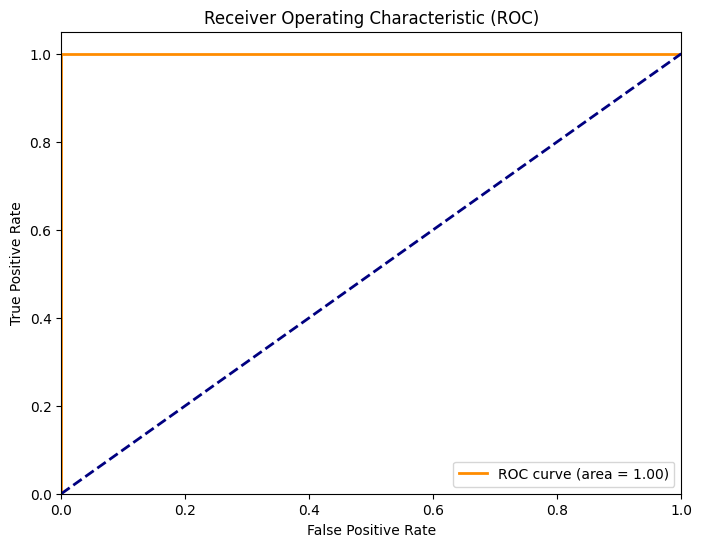

In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


### **count plot** --> that shows the distribution of predicted movie success based on the model's output.

<ipython-input-34-3fd65f598fed>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_pred, palette='Set2')


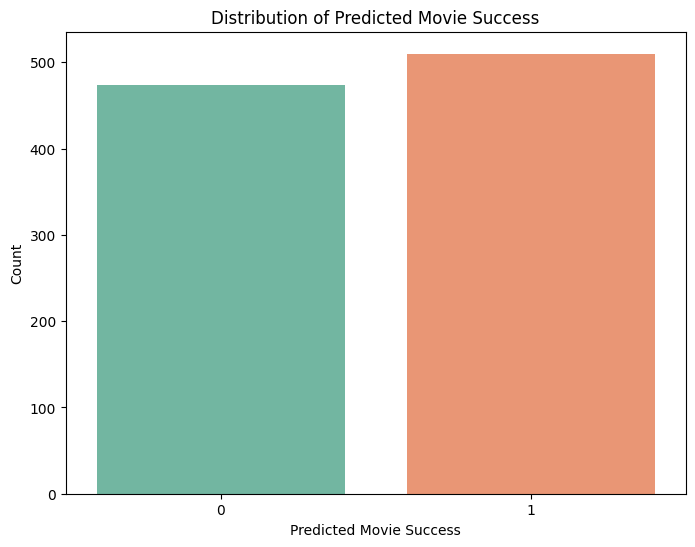

In [ ]:
# Plot distribution of predictions
plt.figure(figsize=(8, 6))
sns.countplot(x=y_pred, palette='Set2')
plt.xlabel('Predicted Movie Success')
plt.ylabel('Count')
plt.title('Distribution of Predicted Movie Success')
plt.show()


In [ ]:
import pickle

# Path to your .pkl file
file_path = '/content/movie_success_genrewise_predictor.pkl'

# Open the file and load the object
with open(file_path, 'rb') as file:
    data = pickle.load(file)

# Now you can use 'data', which contains the object that was stored in the pickle file
print(data)

['director_ratio' 'actor1_ratio' 'actor2_ratio' 'actor3_ratio' 'genres'
 'content_rating' 'language' 'country']


In [ ]:
!pip install streamlit

import streamlit as st
import pandas as pd
import joblib

# Load saved model
model = joblib.load("movie_success_genrewise_predictor.pkl")
df = pd.read_csv("movie_metadata.csv")
df['success'] = (df['imdb_score'] >= 6.5).astype(int)

# Compute success ratios
def compute_genre_success_ratio(df, role_col):
    ratio = df.groupby([role_col, 'genres'])['success'].mean().reset_index()
    ratio.columns = [role_col, 'genres', 'success_ratio']
    return ratio

director_ratio_df = compute_genre_success_ratio(df, 'director_name')
actor1_ratio_df = compute_genre_success_ratio(df, 'actor_1_name')
actor2_ratio_df = compute_genre_success_ratio(df, 'actor_2_name')
actor3_ratio_df = compute_genre_success_ratio(df, 'actor_3_name')

def get_ratio(ratio_df, name, genre):
    match = ratio_df[(ratio_df[ratio_df.columns[0]] == name) & (ratio_df['genres'] == genre)]
    return float(match['success_ratio']) if not match.empty else 0.5

# Streamlit UI
st.title("🎬 Movie Success Predictor")
st.markdown("Predict if a movie will be a **HIT or FLOP** based on past genre-wise performance of director & actors.")

with st.form("movie_form"):
    director = st.text_input("Director Name", "Steven Spielberg")
    actor1 = st.text_input("Actor 1 Name", "Tom Hanks")
    actor2 = st.text_input("Actor 2 Name", "Robin Williams")
    actor3 = st.text_input("Actor 3 Name", "Meryl Streep")
    genre = st.text_input("Genre", "Drama")
    rating = st.text_input("Content Rating", "PG-13")
    language = st.text_input("Language", "English")
    country = st.text_input("Country", "USA")

    submitted = st.form_submit_button("Predict")

if submitted:
    input_df = pd.DataFrame({
        'director_ratio': [get_ratio(director_ratio_df, director, genre)],
        'actor1_ratio': [get_ratio(actor1_ratio_df, actor1, genre)],
        'actor2_ratio': [get_ratio(actor2_ratio_df, actor2, genre)],
        'actor3_ratio': [get_ratio(actor3_ratio_df, actor3, genre)],
        'genres': [genre],
        'content_rating': [rating],
        'language': [language],
        'country': [country]
    })

    prediction = model.predict(input_df)[0]
    result = "🎉 HIT!" if prediction == 1 else "💔 FLOP."

    st.subheader("Prediction Result:")
    st.success(result)


2025-04-21 18:12:06.655 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-21 18:12:06.849 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-04-21 18:12:06.850 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-21 18:12:06.852 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-21 18:12:06.855 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-21 18:12:06.856 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-21 18:12:06.857 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-21 18:12:06.859 Thread 'MainThread': mi

In [ ]:
with open("app.py", "w") as f:
    f.write("""
import streamlit as st
import pandas as pd
import joblib

# Load saved model
model = joblib.load("movie_success_genrewise_predictor.pkl")
df = pd.read_csv("movie_metadata.csv")
df['success'] = (df['imdb_score'] >= 6.5).astype(int)

# Compute success ratios
def compute_genre_success_ratio(df, role_col):
    ratio = df.groupby([role_col, 'genres'])['success'].mean().reset_index()
    ratio.columns = [role_col, 'genres', 'success_ratio']
    return ratio

director_ratio_df = compute_genre_success_ratio(df, 'director_name')
actor1_ratio_df = compute_genre_success_ratio(df, 'actor_1_name')
actor2_ratio_df = compute_genre_success_ratio(df, 'actor_2_name')
actor3_ratio_df = compute_genre_success_ratio(df, 'actor_3_name')

def get_ratio(ratio_df, name, genre):
    match = ratio_df[(ratio_df[ratio_df.columns[0]] == name) & (ratio_df['genres'] == genre)]
    return float(match['success_ratio']) if not match.empty else 0.5

# Streamlit UI
st.title("🎬 Movie Success Predictor")
st.markdown("Predict if a movie will be a **HIT or FLOP** based on past genre-wise performance of director & actors.")

with st.form("movie_form"):
    director = st.text_input("Director Name", "Steven Spielberg")
    actor1 = st.text_input("Actor 1 Name", "Tom Hanks")
    actor2 = st.text_input("Actor 2 Name", "Robin Williams")
    actor3 = st.text_input("Actor 3 Name", "Meryl Streep")
    genre = st.text_input("Genre", "Drama")
    rating = st.text_input("Content Rating", "PG-13")
    language = st.text_input("Language", "English")
    country = st.text_input("Country", "USA")

    submitted = st.form_submit_button("Predict")

if submitted:
    input_df = pd.DataFrame({
        'director_ratio': [get_ratio(director_ratio_df, director, genre)],
        'actor1_ratio': [get_ratio(actor1_ratio_df, actor1, genre)],
        'actor2_ratio': [get_ratio(actor2_ratio_df, actor2, genre)],
        'actor3_ratio': [get_ratio(actor3_ratio_df, actor3, genre)],
        'genres': [genre],
        'content_rating': [rating],
        'language': [language],
        'country': [country]
    })

    prediction = model.predict(input_df)[0]
    result = "🎉 HIT!" if prediction == 1 else "💔 FLOP."

    st.subheader("Prediction Result:")
    st.success(result)
""")




In [ ]:
import pandas as pd
import joblib

# Load the saved model
model = joblib.load("/content/movie_success_genrewise_predictor.pkl")

# Load training data to compute success ratios
df = pd.read_csv("/content/movie_metadata.csv")
df['success'] = (df['imdb_score'] >= 6.5).astype(int)

# Compute success ratio mappings
def compute_genre_success_ratio(df, role_col):
    ratio = df.groupby([role_col, 'genres'])['success'].mean().reset_index()
    ratio.columns = [role_col, 'genres', 'success_ratio']
    return ratio

director_ratio_df = compute_genre_success_ratio(df, 'director_name')
actor1_ratio_df = compute_genre_success_ratio(df, 'actor_1_name')
actor2_ratio_df = compute_genre_success_ratio(df, 'actor_2_name')
actor3_ratio_df = compute_genre_success_ratio(df, 'actor_3_name')

# Prediction function
def predict_movie_success(director_name, actor_1_name, actor_2_name, actor_3_name,
                          genres, content_rating, language, country):

    # Get success ratios from precomputed DataFrames
    def get_ratio(ratio_df, role, genre):
        match = ratio_df[(ratio_df[ratio_df.columns[0]] == role) & (ratio_df['genres'] == genre)]
        return float(match['success_ratio']) if not match.empty else 0.5  # default to 0.5 if no data

    input_data = pd.DataFrame({
        'director_ratio': [get_ratio(director_ratio_df, director_name, genres)],
        'actor1_ratio': [get_ratio(actor1_ratio_df, actor_1_name, genres)],
        'actor2_ratio': [get_ratio(actor2_ratio_df, actor_2_name, genres)],
        'actor3_ratio': [get_ratio(actor3_ratio_df, actor_3_name, genres)],
        'genres': [genres],
        'content_rating': [content_rating],
        'language': [language],
        'country': [country]
    })

    prediction = model.predict(input_data)
    return "🎬 The movie is predicted to be a **HIT!**" if prediction[0] == 1 else "🎬 The movie is predicted to be a **FLOP.**"
director = "James Cameron"         # Famous for action/sci-fi hits like Terminator, Avatar
actor_1 = "Arnold Schwarzenegger"  # Known for successful action roles
actor_2 = "Linda Hamilton"
actor_3 = "Michael Biehn"
genres = "Action|Sci-Fi"
content_rating = "R"
language = "English"
country = "USA"

result = predict_movie_success(director, actor_1, actor_2, actor_3, genres, content_rating, language, country)
print(result)
print(df)


🎬 The movie is predicted to be a **HIT!**
      color      director_name  num_critic_for_reviews  duration  \
0     Color      James Cameron                   723.0     178.0   
1     Color     Gore Verbinski                   302.0     169.0   
2     Color         Sam Mendes                   602.0     148.0   
3     Color  Christopher Nolan                   813.0     164.0   
4       NaN        Doug Walker                     NaN       NaN   
...     ...                ...                     ...       ...   
5038  Color        Scott Smith                     1.0      87.0   
5039  Color                NaN                    43.0      43.0   
5040  Color   Benjamin Roberds                    13.0      76.0   
5041  Color        Daniel Hsia                    14.0     100.0   
5042  Color           Jon Gunn                    43.0      90.0   

      director_facebook_likes  actor_3_facebook_likes      actor_2_name  \
0                         0.0                   855.0  Joel David 

<ipython-input-13-62b56a684111>:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(match['success_ratio']) if not match.empty else 0.5  # default to 0.5 if no data


In [ ]:
# Save DataFrame to Excel
df.to_excel("movie_data_summary.xlsx", index=False)

# To download the file
from google.colab import files
files.download("movie_data_summary.xlsx")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>